In [2]:
import time
import os
import importlib

from pprint import pprint
from collections import defaultdict
from pathlib import Path
from more_itertools import grouper
from itertools import islice, chain, zip_longest, repeat

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.axes as ax

from scipy import io
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import cut_tree

from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

from Modules import utils, plot_utils

In [3]:
importlib.reload(utils)
data_dir='../shared_folder'
writing_dir='../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

Read file and datasets checks

In [7]:
# with np.load(f'{data_dir}/Bombyx/raw_data/X_long.npz') as f:
#     long = f['reads']
# with np.load(f'{data_dir}/Bombyx/raw_data/X_reads.npz') as f:
#     reads = f['reads']

In [ ]:
total = 0
for i in range(len(long)):
    assert(len(long[i]) == len(long[i].rstrip()))
    total += len(long[i])
print(total)
total2 = 0
for i in range(len(reads)):
    assert(len(reads[i]) == len(reads[i].rstrip()))
    total2 += len(reads[i])
print(total2)

In [9]:
with np.load(f'{data_dir}/Judith-H3K9me3/raw_data/Control_reads.npz') as f:
    reads = f['reads']
print(reads.shape)
# sequences = utils.remove_reads_with_N(reads, tolerance=0)
# print(len(sequences))

(40956444,)


In [ ]:
data = 'CENPT'
model_name = 'model_inception2'
threshold = 0.75
with np.load(f'{data_dir}/{data}/results/{model_name}/seqs_{data}_over_{threshold}_with_{model_name}.npz') as f:
    reads = f['reads']
print(reads.shape)
sequences = utils.remove_reads_with_N(reads, tolerance=0)
print(len(sequences))

In [ ]:
dico = utils.check_read_lengths(reads)
dico = dict(sorted(dico.items(), reverse=True))
print('{read_length: nb_reads}')
print(dico)

In [ ]:
with np.load(f'{data_dir}/H3K9me3/dataset30M.npz') as f:
    reads = f['x_test']

In [10]:
# with np.load(f'{data_dir}/HEK293-ZFAT/raw_data/Control_reads_deduped.npz') as f:
#     reads = f['reads']
# print(reads.shape)
# sequences = utils.remove_reads_with_N(reads, tolerance=0)
# print(len(sequences))

print('Looking for read duplicates')
dico = utils.find_duplicates(reads, one_hot=False, batch_size=50_000_000, print_freq=20_000_000)
values = list(dico.values())
print('Looking for duplicate level duplicates')
dico2 = utils.find_duplicates(values, batch_size=100_000_000, print_freq=20_000_000)
dico2 = dict(sorted(dico2.items(), reverse=True))
print('{duplicate_level: nb_unique_reads}')
print(dico2)
print('top 5 duplicate level reads:', list(dico2.keys())[:5])

# print('Looking for read duplicates')
# dico = utils.find_duplicates(sequences, one_hot=False, batch_size=50_000_000, print_freq=20_000_000)
# values = list(dico.values())
# print('Looking for duplicate level duplicates')
# dico2 = utils.find_duplicates(values, batch_size=100_000_000, print_freq=20_000_000)
# dico2 = dict(sorted(dico2.items(), reverse=True))
# print('{duplicate_level: nb_unique_reads}')
# print(dico2)
# print('top 5 duplicate level reads:', list(dico2.keys())[:5])

Looking for read duplicates
1 batches
Processing batch 0
seq 20000000/40956444 duplicates
seq 40000000/40956444 duplicates
seq 40956444/40956444 duplicates
Looking for duplicate level duplicates
1 batches
Processing batch 0
seq 20000000/39066493 duplicates
seq 39066493/39066493 duplicates
{duplicate_level: nb_unique_reads}
{126: 1, 125: 1, 121: 1, 112: 1, 110: 1, 109: 1, 108: 1, 104: 2, 99: 1, 98: 2, 97: 2, 96: 1, 95: 1, 94: 2, 93: 1, 92: 1, 91: 1, 90: 1, 89: 1, 87: 1, 85: 2, 84: 1, 82: 2, 81: 4, 80: 2, 79: 3, 78: 1, 77: 2, 76: 2, 75: 2, 74: 6, 73: 8, 72: 4, 71: 7, 70: 7, 69: 5, 68: 5, 67: 11, 66: 10, 65: 11, 64: 13, 63: 16, 62: 10, 61: 16, 60: 18, 59: 22, 58: 17, 57: 21, 56: 32, 55: 19, 54: 35, 53: 43, 52: 33, 51: 32, 50: 52, 49: 46, 48: 35, 47: 46, 46: 53, 45: 53, 44: 61, 43: 86, 42: 87, 41: 89, 40: 88, 39: 105, 38: 101, 37: 122, 36: 142, 35: 152, 34: 173, 33: 171, 32: 203, 31: 197, 30: 230, 29: 261, 28: 315, 27: 326, 26: 388, 25: 389, 24: 457, 23: 529, 22: 573, 21: 705, 20: 804, 19:

In [15]:
selected_reads = [k for k, v in dico.items() if v == 110]
print(selected_reads)
print(dico[selected_reads[0]])

['CAGACTTTACAAACAGAGTGTTTCCTAACTGCTCTATGAAAAGAAAGGTTAAACTCTGTGAGTTGAACGCACACATCACAAAGGAGTTTCTGAGAATCATT']
110


In [ ]:
# human telomere sequences
seq_list = [
    'CTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAAC',
    'CCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAA',
    'CCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTA',
    'ACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCT',
    'TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACC',
    'AACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCC',
    'GGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTA',
    'GTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAG',
    'TTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGG',
    'TAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGG',
    'AGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGT',
    'GGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTT'
]
for seq in seq_list:
    if seq in dico.keys():
        print(dico[seq], seq)
    else:
        print(0, seq)

In [ ]:
x = list(dico.keys())
y = list(dico.values())
plt.plot(x, y)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('occurences')
plt.xlabel('duplicate level')
plt.show()
plt.close()

In [3]:
with np.load(f'{data_dir}/Judith-H3K9me3/dataset.npz') as dataset:
    y_train = dataset['y_train']
    y_valid = dataset['y_valid']
    y_test = dataset['y_test']
print('total number of reads:',len(y_train) + len(y_valid) + len(y_test))
print('train:', len(y_train), 'valid:', len(y_valid), 'test:', len(y_test))
print('pos_train:', len(y_train[y_train == 1]), 'pos_valid', len(y_valid[y_valid == 1]), 'pos_test', len(y_test[y_test == 1]))

total number of reads: 60000000
train: 42000000 valid: 9000000 test: 9000000
pos_train: 21000000 pos_valid 4500000 pos_test 4500000


In [28]:
with np.load(f'{data_dir}/Judith-H3K4me3/sharded_dataset/valid_0.npz') as f:
    ids = f['ids']
    one_hots = f['one_hots']

In [29]:
print(one_hots.shape)
print(ids[-10:])

(8388608, 101, 4)
['@A00514:1145:HJ2NKDRX2:2:2109:32163:26913 1:N:0:ATATGGAT+TAATACAG'
 '@A00514:1145:HJ2NKDRX2:1:2219:14868:31814 1:N:0:GCGCAAGC+CGGCGTGA'
 '@A00514:1145:HJ2NKDRX2:2:2278:31313:1141 1:N:0:ATATGGAT+TAATACAG'
 '@A00514:1145:HJ2NKDRX2:2:1256:22688:23343 1:N:0:GCGCAAGC+CGGCGTGA'
 '@A00514:1145:HJ2NKDRX2:2:2256:22788:11146 1:N:0:ATATGGAT+TAATACAG'
 '@A00514:1145:HJ2NKDRX2:1:2269:22923:5181 1:N:0:GCGCAAGC+CGGCGTGA'
 '@A00514:1145:HJ2NKDRX2:1:1135:32597:4335 1:N:0:ATATGGAT+TAATACAG'
 '@A00514:1145:HJ2NKDRX2:2:2265:23330:19977 1:N:0:GCGCAAGC+CGGCGTGA'
 '@A00514:1145:HJ2NKDRX2:2:1122:14534:11350 1:N:0:ATATGGAT+TAATACAG'
 '@A00514:1145:HJ2NKDRX2:2:2123:18231:32095 1:N:0:GCGCAAGC+CGGCGTGA']


Plot test distribution

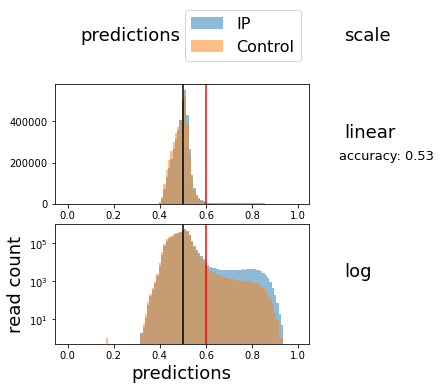

In [32]:
data = 'Judith-H3K4me3'
dataset_name = 'sharded_dataset'
model_name = 'model_inception3.0'
load_hist = False
hist_file = f'distrib_{model_name}_test_hist100000'
relabeled = False
new_labels = 'dataset_rel8'
single_pred_array = True
sharded = True
if load_hist:
    with np.load(f'{writing_dir}/{data}/results/{model_name}/{hist_file}.npz') as f:
        histIP = f['IP']
        histControl = f['Control']
    bins = np.linspace(0, 1, len(histIP)+1)
    win_start = 80000
    win_stop = 80100
    histIP, histControl, bins = histIP[win_start:win_stop], histControl[win_start:win_stop], bins[win_start:win_stop+1]
else:
    if single_pred_array:
        if relabeled:
            with np.load(f'{data_dir}/{data}/results/{model_name}/distrib_{model_name}_test.npz') as f:
                preds = f['pred']
            with np.load(f'{data_dir}//{data}/{new_labels}.npz') as f:
                y_test = f['y_test']
        else:
            with np.load(f'{data_dir}/{data}/results/{model_name}/distrib_{model_name}_test.npz') as f:
                preds = f['pred']
            if sharded:
                y_test = np.zeros(len(preds), dtype=bool)
                y_test[::2] = 1
            else:
                with np.load(f'{data_dir}/{data}/{dataset_name}.npz') as f:
                    y_test = f['y_test']
        predIP = preds[y_test == 1]
        predControl = preds[y_test == 0]
    else:
        with np.load(f'{data_dir}/{data}/results/distrib_{model_name}_test.npz') as f:
                predIP = f['predIP']
                predControl = f['predControl']
    accuracy = (len(predIP[predIP > 0.5]) + len(predControl[predControl < 0.5])) / (len(predIP) + len(predControl))
    n_bins = 100
    histIP, bins = np.histogram(predIP, bins=n_bins, range=(0, 1))
    histControl = np.histogram(predControl, bins=n_bins, range=(0, 1))[0]

widths = [5, 1]
heights = [1.2] + [2.5]*2
fig = plt.figure(figsize=(np.sum(widths), np.sum(heights)))
# fig.suptitle(f"Distribution of predictions of {model_name} on {data} for IP and Control reads")
gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

ax0_top = plt.subplot(gs[0, 0])
label_col0 = 'predictions'
ax0_top.annotate(label_col0, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax0_top.axis('off')

ax1_top = plt.subplot(gs[0, 1])
label_col1 = 'scale'
ax1_top.annotate(label_col1, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax1_top.axis('off')

for nrow in range(1,3):

    ax0 = plt.subplot(gs[nrow, 0])

    ax0.bar(bins[:-1], histIP, width=np.diff(bins), label='IP', alpha=0.5)
    ax0.bar(bins[:-1], histControl, width=np.diff(bins), label='Control', alpha=0.5)

    if not load_hist:
        ax0.axvline(x=0.5, color='black')#, label='t0.5')
        thres = 0.6
        ax0.axvline(x=thres, color='red')#, label=f't{thres}')
    
    ax1 = plt.subplot(gs[nrow, 1])
    if nrow == 1:
        label = 'linear'
        if not load_hist:
            ax1.annotate(f'accuracy: {round(accuracy, 2)}', (0, 0.4), xycoords='axes fraction', va='center', fontsize=13)
    elif nrow == 2:
        label = 'log'
        ax0.set_yscale('log')
    ax1.annotate(label, (0.1, 0.6), xycoords='axes fraction', va='center', fontsize=18)
    ax1.axis('off')
ax0.set_xlabel("predictions", fontsize=18)
ax0.set_ylabel("read count", fontsize=18)
handles, labels = ax0.get_legend_handles_labels()
ax0_top.legend(handles, labels, loc='right', fontsize=16)

if not os.path.isdir(f'{writing_dir}/{data}/results/{model_name}'):
    os.makedirs(f'{writing_dir}/{data}/results/{model_name}')
fig_start = f'{writing_dir}/{data}/results/{model_name}/distrib_{model_name}_test'
fig_name = fig_start + '.png'
fig_dups = 0
while os.path.exists(fig_name):
    fig_dups += 1
    fig_name = fig_start + f'({fig_dups}).png'
plt.savefig(fig_name, bbox_inches='tight')
if not load_hist:
    np.savez(f'{writing_dir}/{data}/results/{model_name}/distrib_{model_name}_test_hist{n_bins}', IP=histIP, Control=histControl)
plt.show()
plt.close()

Select sequences

In [35]:
if sharded:
    with np.load(f'{data_dir}/{data}/{dataset_name}/test_0.npz') as f:
        x_test = f['one_hots']
else:
    with np.load(f'{data_dir}/{data}/{dataset_name}.npz') as f:
        x_test = f['x_test']
# thres = 0.6
selected_reads = x_test[preds.ravel() > thres, :, :]
print(f'nb of selected reads with thres {thres}:', len(selected_reads))

nb of selected reads with thres 0.6: 172716


In [ ]:
with np.load(f'{data_dir}/{data}/{dataset_name}.npz') as f:
    x_test = f['x_test']
thres0 = 0.83
thres1 = 0.99
preds = preds.ravel()
mask = np.logical_and(preds > thres0, preds < thres1)
selected_reads = x_test[mask, :, :]
print(f'nb of selected reads between {thres0} and {thres1}:', len(selected_reads))

Write into fasta file

In [36]:
# 3m per 10_000_000 seqs of 101 bp
utils.write_fasta(utils.one_hot_to_seq(selected_reads), f'{writing_dir}/{data}/results/{model_name}/seqs_{data}_over_{thres}_with_{model_name}.fasta')

In [ ]:
# 3m per 10_000_000 seqs of 101 bp
utils.write_fasta(utils.one_hot_to_seq(selected_reads), f'{writing_dir}/{data}/results/{model_name}/seqs_{data}_over_{thres0}_below_{thres1}_with_{model_name}.fasta')

Plot training logs

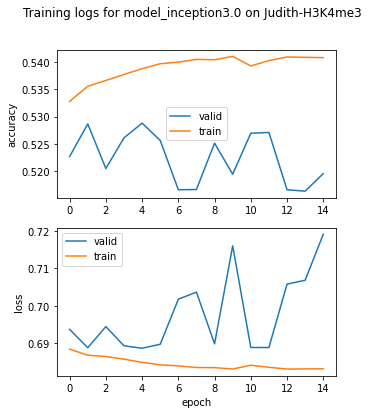

In [37]:
if not os.path.isdir(f'{writing_dir}/{data}/results/{model_name}'):
    os.mkdir(f'{writing_dir}/{data}/results/{model_name}/')
logs = pd.read_csv(f'{data_dir}/{data}/Trainedmodels/{model_name}/epoch_data.csv')
fig = plt.figure(figsize=(5, 6))
fig.suptitle(f'Training logs for {model_name} on {data}')
ax0 = plt.subplot(211)
ax0.plot(logs['val_accuracy'], label='valid')
ax0.plot(logs['accuracy'], label='train')
ax0.set_ylabel('accuracy')
ax0.legend()

ax1 = plt.subplot(212)
ax1.plot(logs['val_loss'], label='valid')
ax1.plot(logs['loss'], label='train')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()
plt.legend()
plt.savefig(f'{writing_dir}/{data}/results/{model_name}/{model_name}_train_log.png', bbox_inches='tight')
plt.show()
plt.close()

In [38]:
IP_accuracy = np.size(predIP[predIP > 0.5]) / np.size(predIP)
Control_accuracy = (np.size(predControl[predControl < 0.5])
                    / np.size(predControl))
print('accuracy: ', (IP_accuracy + Control_accuracy) / 2)
print('IP accuracy: ', IP_accuracy)
print('Control accuracy: ', Control_accuracy)

accuracy:  0.5274401903152466
IP accuracy:  0.5283894538879395
Control accuracy:  0.5264909267425537


Plot test distribution during epochs

4
0.5274401903152466


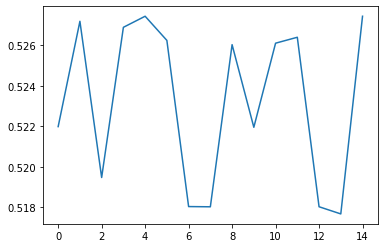

IndexError: index 19 is out of bounds for axis 0 with size 15

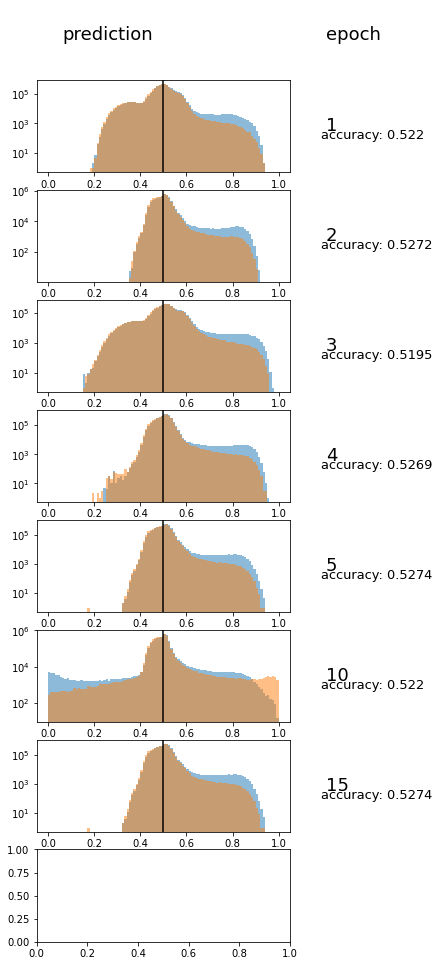

In [39]:
data = 'Judith-H3K4me3'
dataset_name = 'sharded_dataset'
model_name = 'model_inception3.0'
new_labels = 'dataset_rel8'
relabeled = False
sharded = True
preds = np.load(f'{data_dir}/{data}/Trainedmodels/{model_name}/eval_epochs.npy')
# Watching for nan predictions
# for epoch in range(preds.shape[0]):
#     nans = np.count_nonzero(np.isnan(preds[epoch]))
#     print(f'Epoch {epoch}: {nans} nan predictions')
if relabeled:
    with np.load(f'{data_dir}/{data}/{new_labels}.npz') as f:
        y_test = f['y_test']
else:
    if sharded:
        y_test = np.zeros(preds.shape[1], dtype=bool)
        y_test[::2] = 1
    else:
        with np.load(f'{data_dir}//{data}/{dataset_name}.npz') as f:
            y_test = f['y_test']


predsIP = preds[:, y_test == 1]
predsControl = preds[:, y_test == 0]
correct_IP = (predsIP > 0.5)
correct_Control = (predsControl < 0.5)
accuracys = (np.sum(correct_IP, axis=1) + np.sum(correct_Control, axis=1)) / len(y_test)
amax = np.argmax(accuracys)
print(amax)
print(accuracys[amax])
plt.plot(accuracys)
plt.show()
plt.close()

# epochs = range(0, preds.shape[0], 5)
epochs = [0, 1, 2, 3, 4, 9, 14, 19]
widths = [5, 1]
heights = [1.2] + [2]*len(epochs)
fig = plt.figure(figsize=(np.sum(widths), np.sum(heights)))
# fig.suptitle(f"Distribution of predictions of {model_name} during epochs on {data} for IP and Control reads")
gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

ax0_top = plt.subplot(gs[0, 0])
label_col0 = 'prediction'
ax0_top.annotate(label_col0, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax0_top.axis('off')

ax1_top = plt.subplot(gs[0, 1])
label_col1 = 'epoch'
ax1_top.annotate(label_col1, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax1_top.axis('off')

nrow = 1
for epoch in epochs:
    ax0 = plt.subplot(gs[nrow, 0])
    ax0.hist(predsIP[epoch], bins=100, label='IP', alpha=0.5, range=(0,1))
    ax0.hist(predsControl[epoch], bins=100, label='Control', alpha=0.5, range=(0,1))
    ax0.axvline(x=0.5, color='black', label='base thres')
    ax0.set_yscale('log')

    ax1 = plt.subplot(gs[nrow, 1])
    label = f'{epoch+1}'
    ax1.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
    ax1.annotate(f'accuracy: {round(accuracys[epoch], 4)}', (0, 0.4), xycoords='axes fraction', va='center', fontsize=13)
    ax1.axis('off')

    nrow += 1

handles, labels = ax0.get_legend_handles_labels()
ax0_top.legend(handles, labels, loc='right')
ax0.set_xlabel("predictions")
ax0.set_ylabel("read count")
if not os.path.isdir(f'{writing_dir}/{data}/results/{model_name}'):
    os.makedirs(f'{writing_dir}/{data}/results/{model_name}/')
plt.savefig(f'{writing_dir}/{data}/results/{model_name}/distrib_{model_name}_test_epochs.png', bbox_inches='tight')
plt.show()
plt.close()

Compare predictions between 2 models

In [ ]:
data = 'Judith-H3K4me3'
dataset_name = 'dataset4'
model_name = 'model_inception2.2_rel8'
model_name2 = 'model_inception2.2'
new_labels = 'dataset_rel8'
relabeled = True
preds = np.load(f'{data_dir}/{data}/Trainedmodels/{model_name}/eval_epochs.npy')
preds2 = np.load(f'{data_dir}/{data}/Trainedmodels/{model_name2}/eval_epochs.npy')
min_len = min(len(preds), len(preds2))
diff = preds[:min_len] - preds2[:min_len]

if relabeled:
    with np.load(f'{data_dir}/{data}/{new_labels}.npz') as f:
        y_test = f['y_test']
else:
    with np.load(f'{data_dir}//{data}/{dataset_name}.npz') as f:
        y_test = f['y_test']

diffIP = diff[:, y_test == 1]
diffControl = diff[:, y_test == 0]

# epochs = range(0, preds.shape[0], 5)
epochs = [0, 1, 2, 3, 4, 9, 14, 19]
widths = [5, 1]
heights = [1.2] + [2]*len(epochs)
fig = plt.figure(figsize=(np.sum(widths), np.sum(heights)))
# fig.suptitle(f"Distribution of prediction differences of {model_name} during epochs on {data} for IP and Control reads")
gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

ax0_top = plt.subplot(gs[0, 0])
label_col0 = 'prediction difference'
ax0_top.annotate(label_col0, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax0_top.axis('off')

ax1_top = plt.subplot(gs[0, 1])
label_col1 = 'epoch'
ax1_top.annotate(label_col1, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax1_top.axis('off')

nrow = 1
for epoch in epochs:
    ax0 = plt.subplot(gs[nrow, 0])
    ax0.hist(diffIP[epoch], bins=100, label='IP', alpha=0.5, range=(-1, 1))
    ax0.hist(diffControl[epoch], bins=100, label='Control', alpha=0.5, range=(-1, 1))
    # ax0.set_yscale('log')

    ax1 = plt.subplot(gs[nrow, 1])
    label = f'{epoch+1}'
    ax1.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
    ax1.axis('off')

    nrow += 1

handles, labels = ax0.get_legend_handles_labels()
ax0_top.legend(handles, labels, loc='right')
ax0.set_xlabel("difference")
ax0.set_ylabel("read count")
if not os.path.isdir(f'{writing_dir}/{data}/results/{model_name}'):
    os.mkdir(f'{writing_dir}/{data}/results/{model_name}/')
plt.savefig(f'{writing_dir}/{data}/results/{model_name}/distrib_{model_name}_vs_{model_name2}_test_epochs.png', bbox_inches='tight')
plt.show()
plt.close()

Plot GC_content distribution

accuracy : 0.5267540216445923


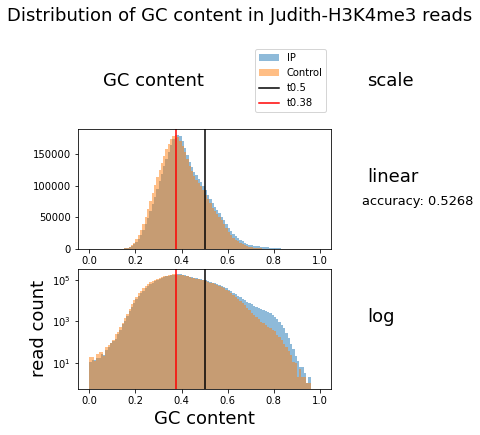

In [41]:
data='Judith-H3K4me3'
dataset_name='sharded_dataset'
sharded = True
if sharded:
    with np.load(f'{data_dir}/{data}/{dataset_name}/test_0.npz') as f:
        x_test = f['one_hots']
    y_test = np.zeros(len(x_test), dtype=bool)
    y_test[::2] = 1
else:
    with np.load(f'{data_dir}/{data}/{dataset_name}.npz') as f:
        x_test = f['x_test']
        y_test = f['y_test']
gc_content = utils.GC_content(x_test)

bins = np.histogram(gc_content, bins=100, range=(0, 1))[1]
accuracy, thres = utils.classify_1D(gc_content, y_test, bins=100)
print('accuracy :', accuracy)

widths = [5, 1]
heights = [1.2] + [2.5]*2
fig = plt.figure(figsize=(np.sum(widths), np.sum(heights)))
# fig.suptitle(f"Distribution of predictions of {model_name} on {data} for IP and Control reads")
gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

ax0_top = plt.subplot(gs[0, 0])
label_col0 = 'GC content'
ax0_top.annotate(label_col0, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax0_top.axis('off')

ax1_top = plt.subplot(gs[0, 1])
label_col1 = 'scale'
ax1_top.annotate(label_col1, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=18)
ax1_top.axis('off')

for nrow in range(1,3):

    ax0 = plt.subplot(gs[nrow, 0])
    ax0.hist(gc_content[y_test == 1], bins, label='IP', alpha=0.5)
    ax0.hist(gc_content[y_test == 0], bins, label='Control', alpha=0.5)
    ax0.axvline(x=0.5, color='black', label=f't0.5')
    ax0.axvline(x=thres, color='red', label=f't{round(thres, 2)}')
    
    ax1 = plt.subplot(gs[nrow, 1])
    if nrow == 1:
        scale_label = 'linear'
        ax1.annotate(f'accuracy: {round(accuracy, 4)}', (0, 0.4), xycoords='axes fraction', va='center', fontsize=13)
    elif nrow == 2:
        scale_label = 'log'
        ax0.set_yscale('log')
    ax1.annotate(scale_label, (0.1, 0.6), xycoords='axes fraction', va='center', fontsize=18)
    ax1.axis('off')
ax0.set_xlabel("GC content", fontsize=18)
ax0.set_ylabel("read count", fontsize=18)
handles, labels = ax0.get_legend_handles_labels()
ax0_top.legend(handles, labels, loc='right')

fig.suptitle(f'Distribution of GC content in {data} reads', fontsize=18)
plt.savefig(f'{writing_dir}/{data}/results/gc_content_classification_{dataset_name}.png', bbox_inches='tight')
plt.show()
plt.close()

Load chromosome

In [5]:
chr_id = 1
overlapping_peaks = {}
# load one_hot_encoded sequence
chr_file = f'../shared_folder/Human/assembly/chr{chr_id}.npz'
with np.load(chr_file) as f:
    one_hot_chr = f['one_hot_genome']
window_size = 101
valid_window_idx = utils.remove_windows_with_N(one_hot_chr, window_size)
print('All windows:', len(one_hot_chr)-window_size+1)
N_mask = np.all(np.logical_not(one_hot_chr), axis=1)
print('Without N:', len(valid_window_idx))

# # load sequence with soft masked repeats
# with np.load(f'{data_dir}/Human/assembly/chr{chr_id}_seq.npz') as f:
#     chr_seq = f['reads'][0]
# chr_seq = np.array(list(chr_seq))
# repeats_idx, = np.where(chr_seq > 'Z')
# print(len(repeats_idx), 'bases in repeats')

# load repeat annotation
repeats = utils.parse_repeats(f'{data_dir}/Human/annotations/repeats/hg38.fa.out', window_size)
chr_repeats = repeats[f'{chr_id}']

All windows: 248956322
Without N: 230469111


Load predictions

In [6]:
data = 'H3K9me3'
model_name = 'model_inception2.2'
model_name1 = 'model_inception2.2.rep1'
model_name_rel = 'model_inception2.2_rel8'
pred_on_genome = True
relabeled = False
if pred_on_genome:
    with np.load(f'{data_dir}/{data}/results/{model_name}/preds_on_genome.npz') as f:
        preds0 = f[f'chr{chr_id}']
    with np.load(f'{data_dir}/{data}/results/{model_name1}/preds_on_genome.npz') as f:
        preds1 = f[f'chr{chr_id}']
    if relabeled:
        with np.load(f'{data_dir}/{data}/results/{model_name_rel}/preds_on_genome.npz') as f:
            preds_rel = f[f'chr{chr_id}']
else:
    with np.load(f'{data_dir}/{data}/results/{model_name}/preds_on_chr{chr_id}.npz') as f:
        preds0 = f['preds']
    with np.load(f'{data_dir}/{data}/results/{model_name1}/preds_on_chr{chr_id}.npz') as f:
        preds1 = f['preds']
    if relabeled:
        with np.load(f'{data_dir}/{data}/results/{model_name_rel}/preds_on_chr{chr_id}.npz') as f:
            preds_rel = f['preds']

Load peaks, logFC and p-value

In [7]:
files = {
    'CTCF': {
        'peaks': 'ENCFF748YHT.bed',
        'p_value': 'ENCFF701JJR.bigWig',
        'logFC': 'ENCFF902EIC.bigWig',
    },
    'H3K27ac': {
        'peaks': 'ENCFF553YTG.bed',
        'p_value': 'ENCFF472QZS.bigWig',
        'logFC': 'ENCFF408XBB.bigWig',
    },
    'H3K27me3': {
        'peaks': 'ENCFF968KLE.bed',
        'p_value': 'ENCFF805LJE.bigWig',
        'logFC': 'ENCFF463LIU.bigWig',
    },
    'H3K9me3': {
        'peaks': 'ENCFF411TKR.bed',
        'p_value': 'ENCFF042EJN.bigWig',
        'logFC': 'ENCFF088IKU.bigWig',
    },
}
peaks_dict = utils.parse_bed_peaks(f'{data_dir}/{data}/raw_data/peaks/{files[data]["peaks"]}', window_size)
p_vals = utils.load_annotation(f'{data_dir}/{data}/raw_data/p_value/{files[data]["p_value"]}', chr_id, window_size)
log_fc = utils.load_annotation(f'{data_dir}/{data}/raw_data/logFC/{files[data]["logFC"]}', chr_id, window_size)
# alt_peaks_dict_CTCF = utils.parse_bed_peaks(f'{data_dir}/{data}/raw_data/peaks/ENCFF855IQA.bed', window_size)

# other_data = 'H3K27ac'
# other_peaks_dict = utils.parse_bed_peaks(f'{data_dir}/{other_data}/raw_data/peaks/{files[other_data]["peaks"]}', window_size)
# other_p_vals = utils.load_annotation(f'{data_dir}/{other_data}/raw_data/p_value/{files[other_data]["p_value"]}', chr_id, window_size)
# other_log_fc = utils.load_annotation(f'{data_dir}/{other_data}/raw_data/logFC/{files[other_data]["logFC"]}', chr_id, window_size)

In [8]:
# z-score, mean and smooth
preds = (preds0 + preds1)/2  # average both replicas
# change predictions on N windows to mean signal
valid_window_mask = np.zeros(len(preds), dtype=bool)
valid_window_mask[valid_window_idx] = True
preds = np.where(valid_window_mask, preds, np.mean(preds[valid_window_idx]))
# # z score
# z_score_preds = utils.z_score(preds, valid_window_idx)
# # Smooth mean
# smooth_size = window_size
# smooth = utils.smooth(preds, smooth_size, mode='linear')
# # z_score_smooth = utils.smooth(z_score_preds, smooth_size, mode='linear')
# log_fc_smooth = utils.smooth(log_fc, 101, mode='linear')
# p_vals_smooth = utils.smooth(p_vals, 101, mode='linear')

# # mean and std with or without windows containing Ns
# mean = np.mean(preds)
# std = np.std(preds)
# rel_preds = preds[valid_window_idx]
# rel_mean = np.mean(rel_preds)
# rel_std = np.std(rel_preds)
# print('mean and std for all windows:', mean, std)
# print('mean and std without Ns:', rel_mean, rel_std)

# # correlations between replicas
# inter_corr = pearsonr(preds0, preds1)
# print(inter_corr, 'correlation rep0-rep1')
# corr_mrel = pearsonr(preds, preds_rel)
# print(corr_mrel, 'correlation mean-relabeled')

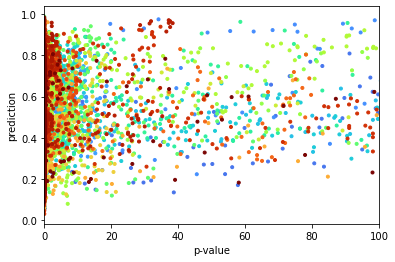

In [208]:
start = 1_000_000
step = 10
stop = 50_000*step + start

color = range(start, stop, step)
plt.scatter(p_vals[valid_window_idx][start:stop:step], preds[valid_window_idx][start:stop:step], marker='.', c=color, cmap=plt.cm.get_cmap('turbo'), vmin=start, vmax=stop)
plt.xlabel('p-value')
plt.ylabel('prediction')
plt.xlim(0, 100)
plt.show()
plt.close()

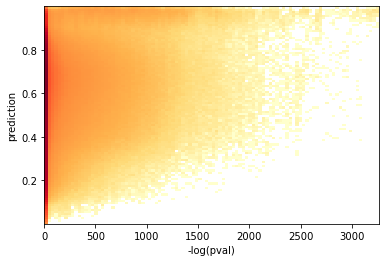

230469111 points drawn


In [546]:
_, bin_edges_x = np.histogram(p_vals[valid_window_idx], bins=100)
_, bin_edges_y = np.histogram(preds[valid_window_idx], bins=100)
bin_edges = [bin_edges_x, bin_edges_y]
plt.hist2d(p_vals[valid_window_idx], preds[valid_window_idx], bins=bin_edges, density=True, norm=mpl.colors.LogNorm(), cmap=plt.cm.get_cmap('YlOrRd'))
plt.xlabel('-log(pval)')
plt.ylabel('prediction')
plt.show()
plt.close()
print(len(valid_window_idx), 'points drawn')

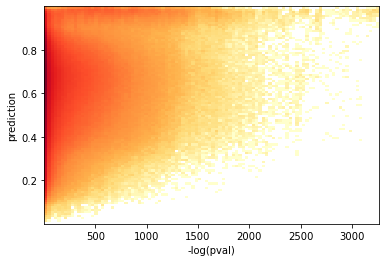

6835154 points drawn


In [547]:
# remove first bin in p-value
# bin_edges[0] = bin_edges_x[1:]
bin_edges_x[0] = min(2, bin_edges_x[1])
bin_edges[0] = bin_edges_x
plt.hist2d(p_vals[valid_window_idx], preds[valid_window_idx], bins=bin_edges, density=True, norm=mpl.colors.LogNorm(), cmap=plt.cm.get_cmap('YlOrRd'))
plt.xlabel('-log(pval)')
plt.ylabel('prediction')
plt.show()
plt.close()
print(np.bincount(p_vals[valid_window_idx] >= bin_edges[0][0])[1], 'points drawn')

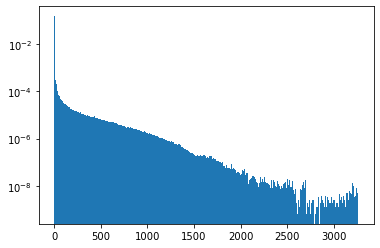

In [67]:
plt.hist(p_vals[valid_window_idx], bins=500, density=True)
plt.yscale('log')
plt.show()
plt.close()

In [9]:
# Total peaks and only high ones
# adjust start and end to sliding window index
chr_peaks = peaks_dict[f'{chr_id}']
print(chr_peaks.shape, f'total peaks in {data}')
high_peaks = chr_peaks[chr_peaks[:,2] >= 1000]
print(high_peaks.shape, f'high peaks in {data}')
# # Peaks of different dataset
# alt_chr_peaks = alt_peaks_dict_CTCF[f'{chr_id}']
# print(alt_chr_peaks.shape, f'alternative peaks in {data}')

(698, 3) total peaks in H3K9me3
(0, 3) high peaks in H3K9me3


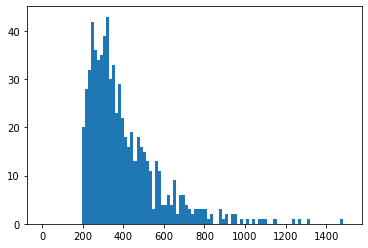

Number of bases in peaks: 279679


In [10]:
# Distribution of peak lengths
peak_lengths = np.diff(chr_peaks[:, :2], axis=1).ravel()
plt.hist(peak_lengths, bins=100, range=(0, 1500))
plt.show()
plt.close()
# high_peaks_lengths = np.diff(high_peaks[:, :2], axis=1).ravel()
# plt.hist(high_peaks_lengths, bins=100)
# plt.show()
# plt.close()

# Total peak length
print('Number of bases in peaks:', np.sum(peak_lengths))

# # For CTCF, alternative peak lengths
# alt_peak_lengths = np.diff(alt_chr_peaks[:, :2], axis=1).ravel()
# plt.hist(alt_peak_lengths[alt_peak_lengths != 810], bins=100, range=(0, 1500))
# plt.show()
# plt.close()
# print('Number of bases in alternative peaks:', np.sum(alt_peak_lengths))

# print(len(peak_lengths[peak_lengths != 810]))
# print(len(alt_peak_lengths[alt_peak_lengths != 810]))
# chr_peaks_reg = chr_peaks[peak_lengths != 810]
# alt_chr_peaks_reg = alt_chr_peaks[alt_peak_lengths != 810]
# uniques, unique_indices = np.unique(np.concatenate((chr_peaks_reg, alt_chr_peaks_reg)), axis=0, return_index=True)
# print(len(uniques))
# alt_specific = unique_indices[unique_indices >= len(chr_peaks_reg)]
# alt_specific_peaks_reg = alt_chr_peaks[alt_specific]

# # Distribution of peak scores
# plt.hist(alt_specific_peaks_reg[:, 2], bins=100)
# plt.show()
# plt.close()

In [602]:
print(chr_peaks[peak_lengths!=810].shape, f'regular overlapping peaks in {data}')
overlap_idx, chr_peaks_reg = utils.self_overlapping_peaks(chr_peaks[peak_lengths!=810])
print(chr_peaks_reg.shape, f'regular peaks in {data}')

(3990, 3) regular overlapping peaks in CTCF
(3565, 2) regular peaks in CTCF


In [603]:
# Correlation between p-value and predicitons
corr_mean = pearsonr(preds, p_vals)
print(corr_mean, 'correlation mean-(-log(pval))')
# Correlation where p-value is high
pval_thres = 2
pvals_ishigh = np.argwhere(p_vals >= pval_thres).ravel()
corr_mean = pearsonr(preds[pvals_ishigh], p_vals[pvals_ishigh])
print(corr_mean, 'correlation mean-(-log(pval)) on p_values higher than', pval_thres)

(0.04027849895440829, 0.0) correlation mean-(-log(pval))
(0.13649912245712012, 0.0) correlation mean-(-log(pval)) on p_values higher than 2


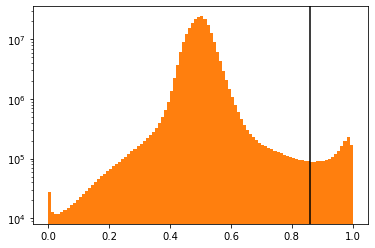

In [11]:
# # Distribution of predictions on all windows
plt.hist(preds[valid_window_idx], bins=100, range=(0, 1), color=colors[1])
plt.yscale('log')
plt.axvline(x=0.86, color='black')
plt.show()
plt.close()

# # Distribution of predictions on N free windows
# plt.hist(preds[valid_window_idx], bins=100, range=(0, 1))
# plt.show()
# plt.close()


In [ ]:
# CTCF_strange_peaks = other_chr_peaks[peak_lengths == 810]
# print(CTCF_strange_peaks.shape, 'strange peaks')
# strange_peaks_indices = CTCF_strange_peaks[:, :1] + np.expand_dims(np.arange(810), axis=0)
# strange_peaks_one_hot = one_hot_chr[strange_peaks_indices]
# strange_peaks_seq = utils.one_hot_to_seq(strange_peaks_one_hot)
# utils.write_fasta(strange_peaks_seq, f'{data_dir}/CTCF/raw_data/peaks/strange_peaks_seqs.fasta')

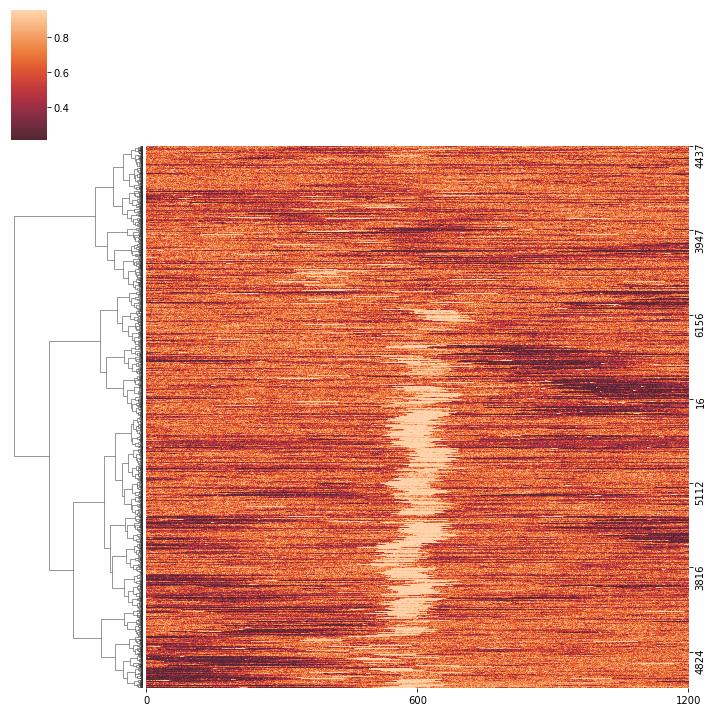

In [13]:
# Metaplot of predictions over mid peaks
mid_peaks = (chr_peaks[:, 0] + chr_peaks[:, 1]) // 2
window_half_size = 600
clust, means, window = utils.metaplot_over_indices(preds, mid_peaks, window_half_size, plot='clustermap', res_dir=f'{writing_dir}/{data}/results/{model_name}', data=data, chr=f'chr{chr_id}')

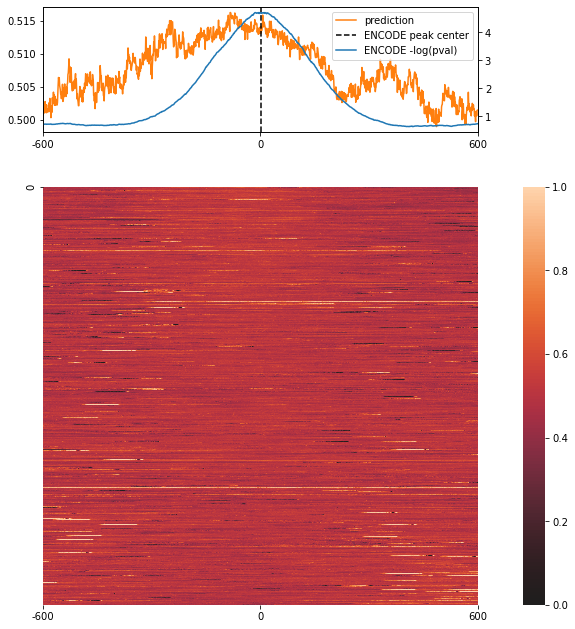

In [12]:
# Metaplot of predictions over mid peaks
# chr_peaks810 = chr_peaks[peak_lengths == 810]
# chr_peaks_reg = chr_peaks[peak_lengths != 810]
# alt_chr_peaks810 = alt_chr_peaks[alt_peak_lengths == 810]
# alt_chr_peaks_reg = alt_chr_peaks[alt_peak_lengths != 810]
mid_peaks = (chr_peaks[:, 0] + chr_peaks[:, 1]) // 2
window_half_size = 600
corrs, means, window = utils.metaplot_over_indices(preds, mid_peaks, window_half_size, label='prediction', compare=(p_vals, 'ENCODE -log(pval)'), plot='heatmap', res_dir=f'{writing_dir}/{data}/results/{model_name}', data=data, chr=f'chr{chr_id}')

In [ ]:
n_clusters = 5
cluster_idx = cut_tree(clust.dendrogram_row.linkage, n_clusters).ravel()
clusters = [np.where(cluster_idx == i)[0] for i in range(n_clusters)]

clust_order = np.array(clust.dendrogram_row.reordered_ind)
samples = [np.where(clust_order == cluster[0])[0] for cluster in clusters]
print('cluster indices ordered from top to bottom', np.argsort(samples, axis=0).ravel())

mean_order = np.argsort(corrs)[::-1]
cluster_idx_mean_order = cluster_idx[mean_order]
plt.scatter(np.arange(len(mean_order)), cluster_idx_mean_order, marker='.')
plt.show()
plt.close()

(937838, 938598, 1000)


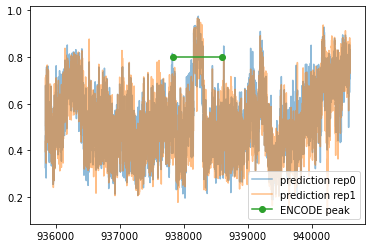

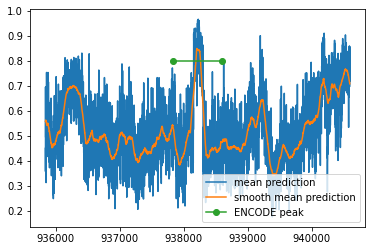

In [51]:
# plot of predictions over chosen peak
i = 13
peak_start, peak_end, score = chr_peaks[i]
print((peak_start, peak_end, score))
window = np.arange(peak_start-2000, peak_end+2000)
# both replicas
plt.plot(window, preds0[window], label='prediction rep0', alpha=0.5)
plt.plot(window, preds1[window], label='prediction rep1', alpha=0.5)
plt.plot([peak_start, peak_end], [0.8, 0.8], marker = 'o', label='ENCODE peak')
plt.legend(loc='lower right')
plt.show()
plt.close()
# mean vs smooth mean
plt.plot(window, preds[window], label='mean prediction')
plt.plot(window, smooth[window], label='smooth mean prediction')
plt.plot([peak_start, peak_end], [0.8, 0.8], marker = 'o', label='ENCODE peak')
plt.legend(loc='lower right')
plt.show()
plt.close()

15455 peaks found
highest length peak: 2497


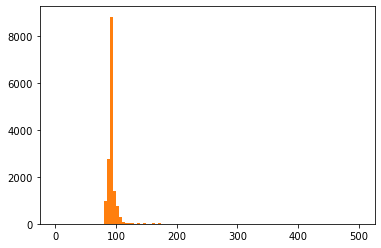

In [662]:
# Find peaks in prediction with custom function and plot lengths
pred_thres = 0.86
pred_peaks = utils.find_peaks(preds, pred_thres=pred_thres, length_thres=80, tol=20)
lengths = np.sort(np.diff(pred_peaks, axis=1).ravel())
distances = np.sort(pred_peaks[1:, 0] - pred_peaks[:-1, 1])  # check distances between peaks
print(pred_peaks.shape[0], 'peaks found')
MAX=500
print('highest length peak:', np.max(lengths))
plt.hist(lengths, bins=100, range=(-0.5, MAX+0.5), color=colors[1])
# plt.yscale('log')
# plt.xscale('log')
plt.show()
plt.close()

3 chr peaks overlap with pred peaks
5 pred peaks overlap with chr peaks
695 chr peaks do not overlap
15450 pred peaks do not overlap


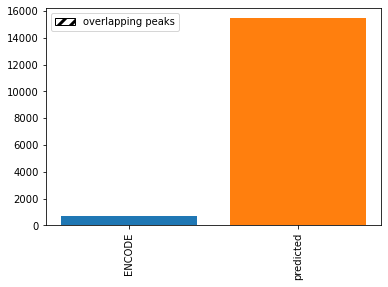

In [663]:
# find overlaps between predicted peaks and ENCODE peaks
(chr_overlap, pred_overlap), (chr_non_overlap, pred_non_overlap) = utils.overlapping_peaks(chr_peaks, pred_peaks)
print(len(chr_overlap), 'chr peaks overlap with pred peaks')
print(len(pred_overlap), 'pred peaks overlap with chr peaks')
print(len(chr_non_overlap), 'chr peaks do not overlap')
print(len(pred_non_overlap), 'pred peaks do not overlap')
peaks = [len(chr_overlap), len(pred_overlap)]
peaks2 = [len(chr_non_overlap), len(pred_non_overlap)]
overlapping_peaks[data] = [peaks, peaks2]
# Plot overlapping peaks
plt.rcParams['hatch.linewidth'] = 3.0
pos = np.arange(2)
fig, ax = plt.subplots()
ax.bar(pos, peaks, edgecolor='black', color=colors, hatch=['/'])
ax.bar(pos, peaks2, bottom=peaks, color=colors)
ax.set_xticks(pos)
ax.set_xticklabels(['ENCODE', 'predicted'], rotation='vertical')
ax.legend(handles=[mpl.patches.Patch(facecolor='none', edgecolor='black', hatch='//')], labels=['overlapping peaks'])
plt.show()
plt.close()

In [664]:
overlapping_peaks

{'CTCF': [[2585, 2682], [980, 2988]],
 'H3K27ac': [[1449, 2674], [3121, 3780]],
 'H3K27me3': [[425, 880], [2898, 4804]],
 'H3K9me3': [[3, 5], [695, 15450]]}

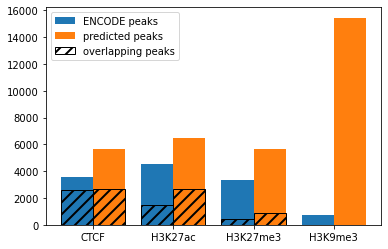

In [665]:
plt.rcParams['hatch.linewidth'] = 2.0
major_labels = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K9me3']
p_os, p_nos, c_os, c_nos = [], [], [], []
for key in major_labels:
    (c_o, p_o), (c_no, p_no) = overlapping_peaks[key]
    p_os.append(p_o)
    p_nos.append(p_no)
    c_os.append(c_o)
    c_nos.append(c_no)
pos = np.arange(4)*2.5
width = 1
fig, ax = plt.subplots()
ax.bar(pos - width/2, c_os, width, edgecolor='black', color=colors[0], hatch=['//'])
ax.bar(pos - width/2, c_nos, width, bottom=c_os, color=colors[0], label='ENCODE peaks')
ax.bar(pos + width/2, p_os, width, edgecolor='black', color=colors[1], hatch=['//'])
ax.bar(pos + width/2, p_nos, width, bottom=p_os, color=colors[1], label='predicted peaks')

ax.set_xticks(pos)
ax.set_xticklabels(major_labels)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles + [mpl.patches.Patch(facecolor='none', edgecolor='black', hatch='//')], labels + ['overlapping peaks'])
plt.show()
plt.close()

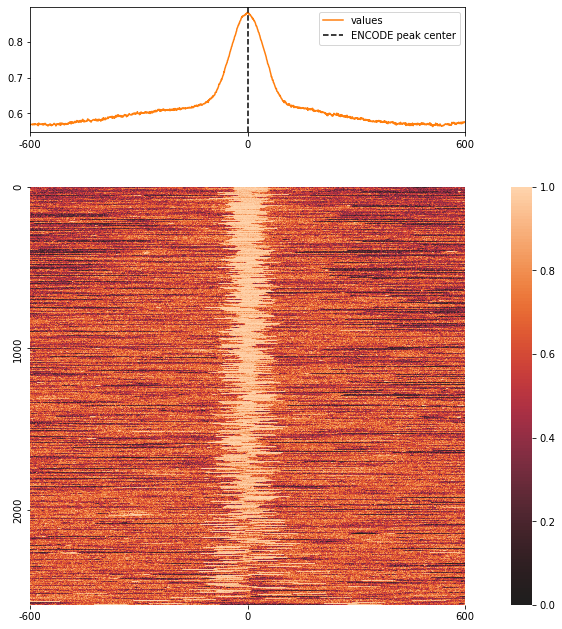

In [579]:
# Metaplot of predictions over mid peaks
peaks = np.array(chr_overlap)
lengths = np.diff(peaks[:, :2], axis=1).ravel()
# print(len(peaks[lengths != 810]), len(peaks[lengths == 810]))
mid_peaks = (peaks[:, 0] + peaks[:, 1]) // 2
window_half_size = 600
corrs, means, window = utils.metaplot_over_indices(preds, mid_peaks, window_half_size, plot='heatmap')

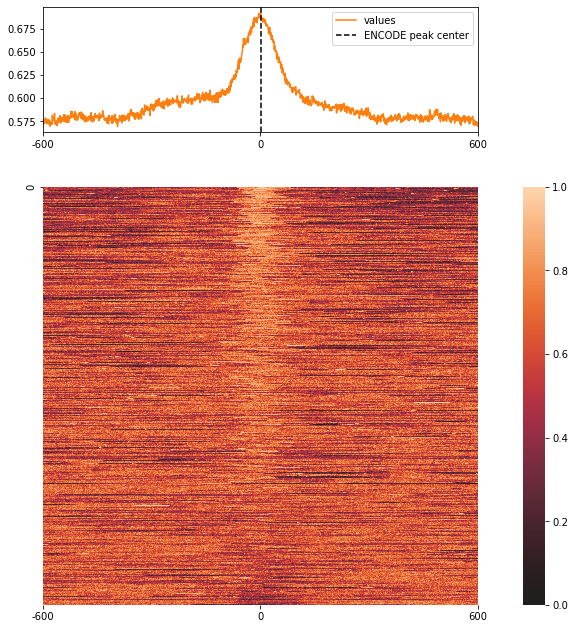

In [580]:
# Metaplot of predictions over mid peaks
peaks = np.array(chr_non_overlap)
lengths = np.diff(peaks[:, :2], axis=1).ravel()
# print(len(peaks[lengths != 810]), len(peaks[lengths == 810]))
# peaks = peaks[lengths != 810]
mid_peaks = (peaks[:, 0] + peaks[:, 1]) // 2
window_half_size = 600
corrs, means, window = utils.metaplot_over_indices(preds, mid_peaks, window_half_size, plot='heatmap')

(869305, 870506, 1000)


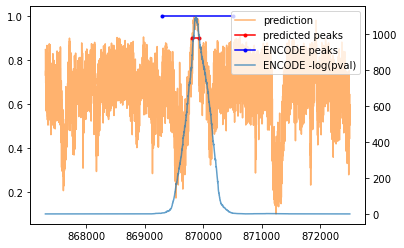

In [589]:
# plot predicted and encode peaks on predicted signal
i = 5
peak_start, peak_end, *score = chr_peaks[i]
print((peak_start, peak_end, *score))
window = np.arange(peak_start-2000, peak_end+2000)
pred_peaks_to_show = utils.find_peaks_in_window(pred_peaks, peak_start-2000, peak_end+2000)
chr_peaks_to_show = utils.find_peaks_in_window(chr_peaks, peak_start-2000, peak_end+2000)

# plot peaks and preds
ax1 = plt.subplot()
ax1.plot(window, preds[window], label='prediction', alpha=0.6, color=colors[1])
ax2 = ax1.twinx()
ax2.plot(window, p_vals[window], label='ENCODE -log(pval)', alpha=0.7)
for id, (start, end, *_) in enumerate(pred_peaks_to_show):
    if id == 0:
        ax1.plot([start, end], [pred_thres, pred_thres], marker = '.', color='red', label='predicted peaks')
    else:
        ax1.plot([start, end], [pred_thres, pred_thres], marker = '.', color='red')
for id, (start, end, *_) in enumerate(chr_peaks_to_show):
    if id == 0:
        ax1.plot([start, end], [1, 1], marker = '.', color='blue', label='ENCODE peaks')
    else:
        ax1.plot([start, end], [1, 1], marker = '.', color='blue')
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2)
plt.show()
plt.close()

In [ ]:
# plot prediction signal vs fold change and p-value
# i = 3
peak_start, peak_end, *score = pred_non_overlap[i]
print(peak_start, peak_end, *score)
window = np.arange(peak_start-2000, peak_end+2000)
ax1 = plt.subplot()
ax1.plot(window, smooth[window], label='prediction', alpha=0.5)
ax1.plot([peak_start, peak_end], [pred_thres, pred_thres], marker = 'o', label='ENCODE peak')
ax2 = ax1.twinx()
ax2.plot(window, p_vals[window], label='p_value', alpha=0.5, color='black')
ax3 = ax1.twinx()
ax3.plot(window, log_fc[window], label='logFC', alpha=0.5, color='red')
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()
plt.legend(handles1 + handles2 + handles3, labels1 + labels2 + labels3, loc='lower right')
plt.show()
plt.close()

In [151]:
print(chr_repeats.keys())
all_chr_repeats = np.array([rep for array in chr_repeats.values() for rep in array])
lengths = np.diff(all_chr_repeats, axis=1).ravel()
print(np.sum(lengths), 'bases in repeats')
print(len(one_hot_chr), f'bases in chr{chr_id}')

dict_keys(['Simple_repeat', 'Satellite/telo', 'LINE/L1', 'DNA/hAT-Charlie', 'SINE/MIR', 'LINE/L2', 'LINE/CR1', 'LTR/ERVL-MaLR', 'SINE/Alu', 'DNA/hAT', 'LTR/ERVL', 'LTR', 'LTR/ERV1', 'DNA/hAT-Tip100', 'Low_complexity', 'DNA/TcMar-Tigger', 'LTR/ERVL?', 'LTR/ERV1?', 'LINE/RTE-X', 'LTR?', 'LTR/ERVK', 'snRNA', 'DNA/MULE-MuDR', 'tRNA', 'DNA?', 'LTR/Gypsy', 'DNA/hAT-Blackjack', 'Retroposon/SVA', 'Satellite', 'srpRNA', 'DNA/hAT-Ac', 'rRNA', 'DNA/TcMar-Tc2', 'SINE/tRNA-Deu', 'LINE/RTE-BovB', 'SINE/5S-Deu-L2', 'DNA/PiggyBac', 'DNA/hAT?', 'Unknown', 'DNA/TcMar-Mariner', 'RC/Helitron', 'LTR/Gypsy?', 'SINE/tRNA-RTE', 'SINE/tRNA', 'DNA/hAT-Tip100?', 'DNA', 'LINE/Penelope', 'LINE/Dong-R4', 'scRNA', 'RNA', 'DNA/PiggyBac?', 'Satellite/centr', 'DNA/TcMar?', 'RC?/Helitron?', 'DNA/TcMar', 'DNA/hAT-Tag1', 'DNA/Merlin', 'DNA/TcMar-Pogo', 'SINE?/tRNA', 'SINE?', 'DNA/PIF-Harbinger'])
118782675 bases in repeats
248956422 bases in chr1


In [593]:
pred_peaks_in_repeats = {}
for family in chr_repeats.keys():
    (pred_peaks_in_repeats[family], _), _ = utils.overlapping_peaks(pred_peaks, chr_repeats[family])
chr_peaks_in_repeats = {}
for family in chr_repeats.keys():
    (chr_peaks_in_repeats[family], _), _ = utils.overlapping_peaks(chr_peaks_reg, chr_repeats[family])
# chr_peaks_reg_in_repeats = {}
# for family in chr_repeats.keys():
#     (chr_peaks_reg_in_repeats[family], _), _ = utils.overlapping_peaks(chr_peaks_reg, chr_repeats[family])
# chr_peaks810_in_repeats = {}
# for family in chr_repeats.keys():
#     (chr_peaks810_in_repeats[family], _), _ = utils.overlapping_peaks(chr_peaks810, chr_repeats[family])

In [594]:
n_pred_peaks = {key: len(value) for key, value in pred_peaks_in_repeats.items()}
n_chr_peaks = {key: len(value) for key, value in chr_peaks_in_repeats.items()}

zero_keys = []
for key, value in n_pred_peaks.items():
    if value == 0 and n_chr_peaks[key] == 0:
        zero_keys.append(key)
for key in zero_keys:
    n_pred_peaks.pop(key)
    n_chr_peaks.pop(key)
# n_chr_peaks_reg = {key: len(value) for key, value in chr_peaks_reg_in_repeats.items()}
# n_chr_peaks810 = {key: len(value) for key, value in chr_peaks810_in_repeats.items()}
# n_families = 0
# for family, value in n_chr_peaks.items():
#     if '?' not in family:
#         print(family, value)
#         n_families += 1
# print(n_families, 'families')

5175 peaks in repeats in ENCODE CTCF
2207 peaks in repeats in predicted CTCF


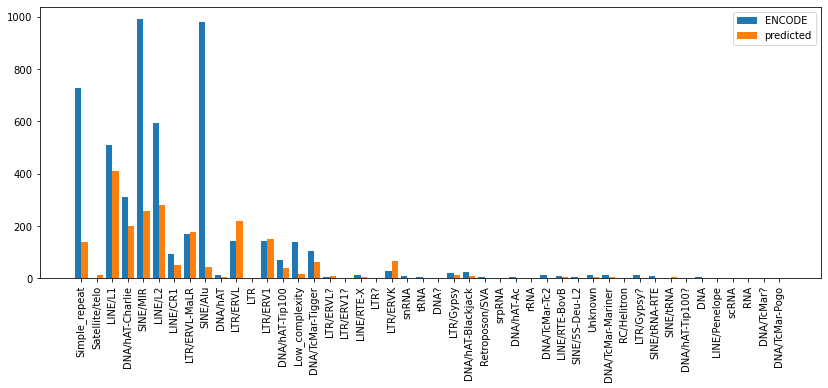

In [595]:
families, peaks = zip(*n_chr_peaks.items())
families2, peaks2 = zip(*n_pred_peaks.items())
print(sum(peaks), f'peaks in repeats in ENCODE {data}')
print(sum(peaks2), f'peaks in repeats in predicted {data}')
assert(families == families2)
pos = np.arange(len(families))*2.5
width = 1
fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(pos - 0.5, peaks, width, label='ENCODE')
ax.bar(pos + 0.5, peaks2, width, label='predicted')
# ax.set_ylim(0, 2500)
ax.set_xticks(pos)
ax.set_xticklabels(families, rotation='vertical')
plt.legend()
plt.show()
plt.close()

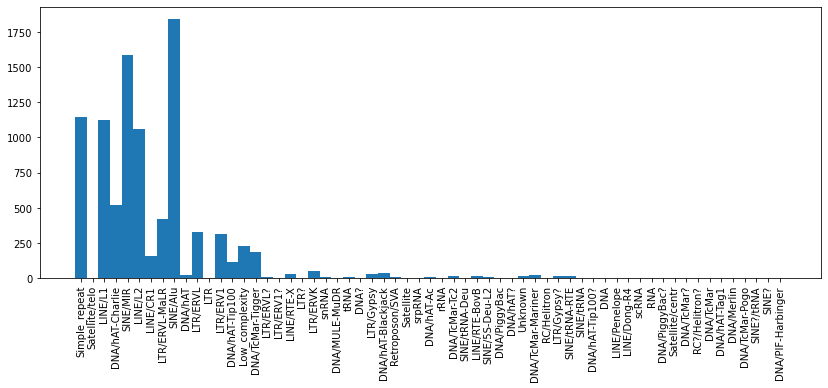

In [123]:
families, peaks = zip(*n_chr_peaks.items())
pos = np.arange(len(families))
width = 1
fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(pos, peaks, width)
ax.set_xticks(pos)
ax.set_xticklabels(families, rotation='vertical')
plt.show()
plt.close()

In [ ]:
with np.load('../data_test/CTCF_IP_dataset/train_0.npz') as f:
    ids = f['ids']
    one_hots = f['one_hots']

In [151]:
print(ids.shape)
print(one_hots.shape)
counter = 0
for i, val in zip(ids, one_hots):
    if counter > 10:
        break
    print(i, utils.one_hot_decode(val))
    counter += 1

(16777216,)
(16777216, 101, 4)
@MONK:482:C8PV4ACXX:5:2316:19138:78248 2:N:0:CAGATC TGTCTTTTTCATCCTTGTCTCTTGCCACTATGCCCCTCACATTTTGTATTAGGGGGAGAAAAAAAATCCACAGTTCCAAGACAAAGATCTTTCACATCAGA
@MONK:482:C8PV4ACXX:5:2113:9200:4575 1:N:0:CAGATC GTTTCCTATTAGTAAATCAACACACGGCATAAATAAATAATTCCTTGTAGCTGGGGTTTTCCTTGTCATTAGAAATAGATAACCAGGGCCTTTTATGCTTG
@MONK:482:C8PV4ACXX:5:2108:4869:2576 2:N:0:CAGATC GAAGGAGGGAGGGAAGGAAGGAAGGAAAAAACCTCCCTGTCCTTTTGGCCCTGAAGGGACCTTCGCTTTCCAAAGGGCTATGGCAAGAAGGGTGGGTCGCA
@MONK:482:C8PV4ACXX:5:1216:7791:51399 1:N:0:CAGATC CTCAGGCCTTGGGCAGGCAGGCTTCAGGATAGGCTTTGATGCTGGATTTTTTTTCTTTTCCAAGTCATTCTCTAATTGAAAATGACTCCATGCAGCTGTCA
@MONK:482:C8PV4ACXX:5:1216:17065:22785 2:N:0:CATATC GATCTGAGAGCCTAGATTCACCCTAGGTAAATTCATGGTACAGGCACACATGGTATATTCACAGATTCTGCAACCTCACAGCCTGGGAGCAGGCGCAGCGC
@MONK:482:C8PV4ACXX:5:1312:6983:56079 1:N:0:CAGATC AAAGAAACATATATAATTTATGGTATAACCTCCATAATGGAATATTGTACAACCATTATGGGGGGAATAAGGAGGGAGTAACTGCTAACGGGTATCAGGTT
@MONK:482:C8PV4ACXX:5:1215:10252:36113 2:N:0:CAGATC

In [65]:
s = 'ATCGGAAGAGCGTCGTGTAGGGAA (AATGATACGGCGA) CCACCGAGATCTACACCCTT TCGCCGTATCATTAAAAAAAAA'
mots = s.split()
print(len(mots[0]+mots[2]+mots[3]))
print(len(s)-5)

66
79


In [16]:
with open('../shared_folder/H3K27me3/results/model_inception2.2/seqs_H3K27me3_over_0.8_with_model_inception2.2.fasta') as file:
    seqs = []
    seq = ''
    for line in file:
        if line.startswith('>'):
            if seq != '':
                seqs.append(seq)
                seq = ''
        else:
            seq += line.rstrip()
    if seq != '':
        seqs.append(seq)

In [24]:
selected = []
for seq in seqs:
    if not('ATCGGAAGAGCGTCGTGTAGG' in seq or 'CGGTGGTCGCCGTATCATTAAAAAAAAA' in seq):
        selected.append(seq)
print(len(selected))
# selected = []
# for seq in seqs:
#     if 'ATCGGAAGAGC' not in seq or 'GTCGTGTAGG' not in seq or 'CGGTGGTCGCCGTATCATTAAAAAAAAA' not in seq:
#         selected.append(seq)
# print(len(selected))

33539


In [22]:
utils.write_fasta(selected, '../shared_folder/H3K27me3/results/model_inception2.2/seqs_H3K27me3_over_0.8_with_model_inception2.2_filtered.fasta')

In [22]:
importlib.reload(utils)
gen = utils.data_generator('../data_test/CTCF_IP_dataset/', 1024*16)
for i in range(10000):
    next(gen)
    if i % 128 == 0:
        print(next(gen))

batch 1/225 on file ../data_test/CTCF_IP_dataset/train_1.npz
batch 130/225 on file ../data_test/CTCF_IP_dataset/train_1.npz
batch 34/1024 on file ../data_test/CTCF_IP_dataset/train_0.npz
batch 163/1024 on file ../data_test/CTCF_IP_dataset/train_0.npz
batch 292/1024 on file ../data_test/CTCF_IP_dataset/train_0.npz
batch 421/1024 on file ../data_test/CTCF_IP_dataset/train_0.npz
batch 550/1024 on file ../data_test/CTCF_IP_dataset/train_0.npz
batch 679/1024 on file ../data_test/CTCF_IP_dataset/train_0.npz
batch 808/1024 on file ../data_test/CTCF_IP_dataset/train_0.npz
batch 937/1024 on file ../data_test/CTCF_IP_dataset/train_0.npz
batch 42/1024 on file ../data_test/CTCF_IP_dataset/train_0.npz
batch 171/1024 on file ../data_test/CTCF_IP_dataset/train_0.npz
batch 300/1024 on file ../data_test/CTCF_IP_dataset/train_0.npz
batch 429/1024 on file ../data_test/CTCF_IP_dataset/train_0.npz
batch 558/1024 on file ../data_test/CTCF_IP_dataset/train_0.npz
batch 687/1024 on file ../data_test/CTCF_IP_da

In [5]:
importlib.reload(utils)
dataset_dir = '../data_test/CTCF_dataset/'
gen = utils.data_generator(dataset_dir, 1024*16)
for i in range(10000):
    next(gen)
    if i % 128 == 0:
        print(next(gen))
for file in Path(dataset_dir).glob('train' + '_*.npy'):
    file.unlink()

batch 1/1024 on file ../data_test/CTCF_dataset/train_0.npz
batch 130/1024 on file ../data_test/CTCF_dataset/train_0.npz
batch 259/1024 on file ../data_test/CTCF_dataset/train_0.npz
batch 388/1024 on file ../data_test/CTCF_dataset/train_0.npz
batch 517/1024 on file ../data_test/CTCF_dataset/train_0.npz
batch 646/1024 on file ../data_test/CTCF_dataset/train_0.npz
batch 775/1024 on file ../data_test/CTCF_dataset/train_0.npz
batch 904/1024 on file ../data_test/CTCF_dataset/train_0.npz
batch 9/1024 on file ../data_test/CTCF_dataset/train_1.npz
batch 138/1024 on file ../data_test/CTCF_dataset/train_1.npz
batch 267/1024 on file ../data_test/CTCF_dataset/train_1.npz
batch 396/1024 on file ../data_test/CTCF_dataset/train_1.npz
batch 525/1024 on file ../data_test/CTCF_dataset/train_1.npz
batch 654/1024 on file ../data_test/CTCF_dataset/train_1.npz
batch 783/1024 on file ../data_test/CTCF_dataset/train_1.npz
batch 912/1024 on file ../data_test/CTCF_dataset/train_1.npz
batch 17/450 on file ../data